In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
SEED = 42

# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

print(f"Device set to: {DEVICE}")

Device set to: cuda


In [2]:
# --- Path Verification ---
print("List of directories in /kaggle/input:")
try:
    print(os.listdir("/kaggle/input"))
except FileNotFoundError:
    print("Input directory not found. Please ensure dataset is added.")

List of directories in /kaggle/input:
['2d-full-slices']


In [3]:
# Define input root
INPUT_ROOT = '/kaggle/input'
CSV_FILENAME = 'all_slices_info.csv'

# Robust search for the CSV file
csv_path = None
dataset_root = None

print(f"\nSearching for {CSV_FILENAME}...")

for root, dirs, files in os.walk(INPUT_ROOT):
    if CSV_FILENAME in files:
        csv_path = os.path.join(root, CSV_FILENAME)
        dataset_root = root
        break

if csv_path is None:
    raise FileNotFoundError(f"Could not find {CSV_FILENAME} in {INPUT_ROOT}")

print(f"Dataset found. CSV Path: {csv_path}")
print(f"Dataset Root: {dataset_root}")


Searching for all_slices_info.csv...
Dataset found. CSV Path: /kaggle/input/2d-full-slices/all_slices_info.csv
Dataset Root: /kaggle/input/2d-full-slices


In [4]:
# --- Data Loading & Preprocessing ---

# 1. Load Data
try:
    df = pd.read_csv(csv_path)
    print("Metadata loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading CSV: {e}")

# --- CRITICAL FIX: Convert Target Column to Integer ---
# Ensure target is numeric (0/1) instead of string (YES/NO)
if df['csPCa'].dtype == 'object':
    print("Converting 'csPCa' column from String to Integer...")
    df['csPCa'] = df['csPCa'].apply(lambda x: 1 if str(x).upper().strip() == 'YES' else 0)

print(f"Target column type: {df['csPCa'].dtype}")
# -----------------------------------------------------

# 2. Prevent Data Leakage: Group Split by 'case_id'
print("\nSplitting data by Patient ID (case_id)...")

if 'case_id' not in df.columns:
    raise ValueError("'case_id' column missing. Cannot perform safe split.")

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=SEED)
train_inds, val_inds = next(splitter.split(df, groups=df['case_id']))

train_df = df.iloc[train_inds].copy()
val_df = df.iloc[val_inds].copy()

# Verify no leakage
train_cases = set(train_df['case_id'].unique())
val_cases = set(val_df['case_id'].unique())
overlap = train_cases.intersection(val_cases)

print(f"Train samples: {len(train_df)} (Patients: {len(train_cases)})")
print(f"Val samples:   {len(val_df)}   (Patients: {len(val_cases)})")

if len(overlap) > 0:
    raise RuntimeError(f"LEAKAGE DETECTED! {len(overlap)} patients are in both sets.")
else:
    print("Sanity Check Passed: No patient overlap.")

# 3. Define Transforms (Xception Input: 299x299)
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 4. Define Dataset Class
class ProstateDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Resolve image path
        # Ensure path is string
        rel_path = str(row['image_rel_path']) 
        img_path = os.path.join(self.root_dir, rel_path)
        
        # Robust loading logic
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            # Fallback attempts for different OS separators
            fixed_path = rel_path.replace('\\', '/')
            img_path_alt = os.path.join(self.root_dir, fixed_path)
            
            if os.path.exists(img_path_alt):
                image = Image.open(img_path_alt).convert('RGB')
            else:
                # Check if images are flat in root
                flat_name = os.path.basename(fixed_path)
                img_path_flat = os.path.join(self.root_dir, flat_name)
                if os.path.exists(img_path_flat):
                    image = Image.open(img_path_flat).convert('RGB')
                else:
                    # Return black image to avoid crash
                    image = Image.new('RGB', (299, 299), (0, 0, 0))

        label = torch.tensor(row['csPCa'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Initialize Loaders
train_dataset = ProstateDataset(train_df, dataset_root, transform=train_transforms)
val_dataset = ProstateDataset(val_df, dataset_root, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Metadata loaded successfully.
Converting 'csPCa' column from String to Integer...
Target column type: int64

Splitting data by Patient ID (case_id)...
Train samples: 26542 (Patients: 1186)
Val samples:   6774   (Patients: 297)
Sanity Check Passed: No patient overlap.



--- Class Distribution (Train Set) ---
csPCa
0    19304
1     7238
Name: count, dtype: int64


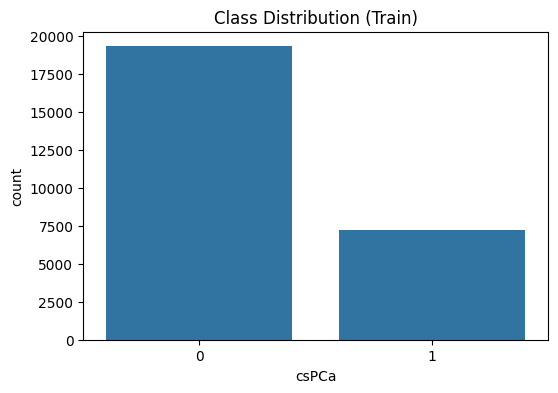

Imbalance Ratio (Neg/Pos): 2.67

--- Random Training Samples ---


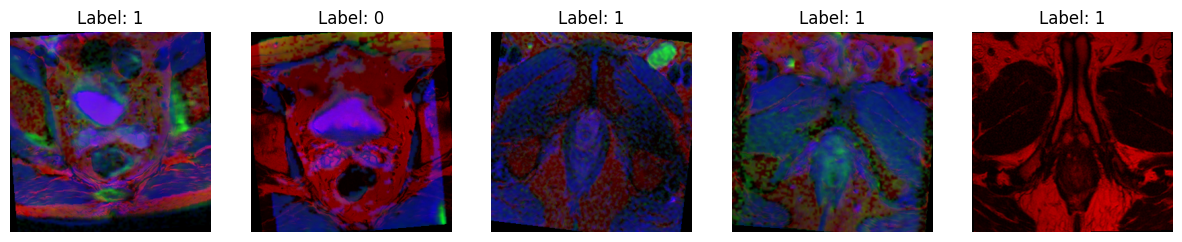

In [5]:
# --- Exploratory Data Analysis (EDA) ---

# 1. Class Distribution
print("\n--- Class Distribution (Train Set) ---")
count_data = train_df['csPCa'].value_counts()
print(count_data)

plt.figure(figsize=(6, 4))
sns.countplot(x='csPCa', data=train_df)
plt.title('Class Distribution (Train)')
plt.show()

# Calculate Imbalance
imbalance_ratio = count_data.iloc[0] / count_data.iloc[1] if len(count_data) > 1 else 0
print(f"Imbalance Ratio (Neg/Pos): {imbalance_ratio:.2f}")

# 2. Visualize Samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        # Un-normalize for display
        img = img * 0.5 + 0.5
        img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {int(label.item())}")
        plt.axis('off')
    plt.show()

print("\n--- Random Training Samples ---")
show_samples(train_dataset)

In [6]:
# --- Xception Architecture Implementation ---

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()
        
        self.skip = None
        if out_filters != in_filters or strides != 1:
            self.skip = nn.Conv2d(in_filters, out_filters, 1, stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))
            
        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x += skip
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=1):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.block1 = Block(64, 128, 2, 2, start_with_relu=False, grow_first=True)
        self.block2 = Block(128, 256, 2, 2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, 2, 2, start_with_relu=True, grow_first=True)

        # Middle Flow (Repeated 8 times)
        self.middle_flow = nn.ModuleList()
        for _ in range(8):
            self.middle_flow.append(Block(728, 728, 3, 1, start_with_relu=True, grow_first=True))

        # Exit Flow
        self.block12 = Block(728, 1024, 2, 2, start_with_relu=True, grow_first=False)
        
        self.conv3 = SeparableConv2d(1024, 1536, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.conv4 = SeparableConv2d(1536, 2048, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # Entry Flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Middle Flow
        for block in self.middle_flow:
            x = block(x)
            
        # Exit Flow
        x = self.block12(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Initialize tqdm progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_val = loss.item()
            running_loss += loss_val * inputs.size(0)
            
            # Update progress bar description
            progress_bar.set_postfix({'batch_loss': f'{loss_val:.4f}'})
            
        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        
        # Validation
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")
        
    return history

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())
            
    total_loss = running_loss / len(loader.dataset)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = 0.5 
        
    binary_preds = (all_preds > 0.5).astype(int)
    
    return total_loss, auc, all_labels, binary_preds

In [8]:
# --- Train Custom Xception ---
print("Initializing Xception...")
model_xception = Xception(num_classes=1).to(DEVICE)

# Weighted Loss for Imbalance
num_pos = train_df['csPCa'].sum()
num_neg = len(train_df) - num_pos
pos_weight_val = num_neg / num_pos if num_pos > 0 else 1.0
pos_weight = torch.tensor([pos_weight_val], device=DEVICE)

print(f"Positive Class Weight: {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_xception.parameters(), lr=LEARNING_RATE)

print("\nStarting Training...")
# This will now show a progress bar
history_xception = train_model(model_xception, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

# Final Eval
_, xception_auc, y_true, y_pred_xception = evaluate_model(model_xception, val_loader, criterion)
print(f"\nFinal Xception AUC: {xception_auc:.4f}")
print(classification_report(y_true, y_pred_xception))

Initializing Xception...
Positive Class Weight: 2.67

Starting Training...


Epoch 1/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.9682 | Val Loss: 1.0781 | Val AUC: 0.5749


Epoch 2/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.8646 | Val Loss: 1.1701 | Val AUC: 0.6082


Epoch 3/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.7729 | Val Loss: 1.2193 | Val AUC: 0.5918


Epoch 4/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.6660 | Val Loss: 1.5129 | Val AUC: 0.6205


Epoch 5/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.5527 | Val Loss: 1.7154 | Val AUC: 0.6343


Epoch 6/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.4453 | Val Loss: 1.9889 | Val AUC: 0.6203


Epoch 7/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.3664 | Val Loss: 2.3235 | Val AUC: 0.6207


Epoch 8/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.2998 | Val Loss: 2.1681 | Val AUC: 0.6152


Epoch 9/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.2546 | Val Loss: 2.7821 | Val AUC: 0.6103


Epoch 10/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.2277 | Val Loss: 2.9409 | Val AUC: 0.5884

Final Xception AUC: 0.5884
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      4632
         1.0       0.40      0.39      0.40      2142

    accuracy                           0.62      6774
   macro avg       0.56      0.56      0.56      6774
weighted avg       0.62      0.62      0.62      6774



In [9]:
# --- Train EfficientNet (From Scratch Comparison) ---
print("Initializing EfficientNet-B0...")
model_effnet = models.efficientnet_b0(weights=None) 
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, 1)
model_effnet = model_effnet.to(DEVICE)

optimizer_eff = optim.Adam(model_effnet.parameters(), lr=LEARNING_RATE)

print("Starting Training...")
history_effnet = train_model(model_effnet, train_loader, val_loader, criterion, optimizer_eff, NUM_EPOCHS)

_, effnet_auc, _, _ = evaluate_model(model_effnet, val_loader, criterion)
print(f"\nFinal EfficientNet AUC: {effnet_auc:.4f}")

Initializing EfficientNet-B0...
Starting Training...


Epoch 1/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 1.0141 | Val Loss: 1.0673 | Val AUC: 0.4758


Epoch 2/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 1.0002 | Val Loss: 1.1136 | Val AUC: 0.5309


Epoch 3/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.9737 | Val Loss: 1.0678 | Val AUC: 0.5635


Epoch 4/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.9440 | Val Loss: 1.1220 | Val AUC: 0.5810


Epoch 5/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.9149 | Val Loss: 1.5943 | Val AUC: 0.5840


Epoch 6/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.8864 | Val Loss: 1.1810 | Val AUC: 0.5609


Epoch 7/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.8563 | Val Loss: 1.2579 | Val AUC: 0.6088


Epoch 8/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.8173 | Val Loss: 1.2704 | Val AUC: 0.6057


Epoch 9/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.7841 | Val Loss: 1.3075 | Val AUC: 0.6119


Epoch 10/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.7449 | Val Loss: 1.3036 | Val AUC: 0.6280

Final EfficientNet AUC: 0.6280


In [10]:
# --- Improvement Strategy: Pretrained Weights + Stronger Augmentation ---

# 1. Enhanced Augmentation
improved_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# New Dataset/Loader
train_dataset_imp = ProstateDataset(train_df, dataset_root, transform=improved_transforms)
train_loader_imp = DataLoader(train_dataset_imp, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 2. Pretrained Model
print("Initializing Pretrained EfficientNet...")
model_imp = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_imp.classifier[1] = nn.Linear(model_imp.classifier[1].in_features, 1)
model_imp = model_imp.to(DEVICE)

optimizer_imp = optim.Adam(model_imp.parameters(), lr=1e-4)

print("Starting Training (Improved)...")
history_imp = train_model(model_imp, train_loader_imp, val_loader, criterion, optimizer_imp, NUM_EPOCHS)

_, imp_auc, _, _ = evaluate_model(model_imp, val_loader, criterion)
print(f"\nFinal Improved AUC: {imp_auc:.4f}")

Initializing Pretrained EfficientNet...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


Starting Training (Improved)...


Epoch 1/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.9311 | Val Loss: 1.0814 | Val AUC: 0.5396


Epoch 2/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.7897 | Val Loss: 1.1420 | Val AUC: 0.5651


Epoch 3/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.6624 | Val Loss: 1.2743 | Val AUC: 0.5693


Epoch 4/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.5513 | Val Loss: 1.3521 | Val AUC: 0.5899


Epoch 5/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.4501 | Val Loss: 1.5813 | Val AUC: 0.5679


Epoch 6/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.3741 | Val Loss: 1.9762 | Val AUC: 0.5910


Epoch 7/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.3166 | Val Loss: 1.9041 | Val AUC: 0.6258


Epoch 8/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.2605 | Val Loss: 1.8497 | Val AUC: 0.5884


Epoch 9/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.2366 | Val Loss: 2.3096 | Val AUC: 0.5776


Epoch 10/10:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.1961 | Val Loss: 3.1746 | Val AUC: 0.5871

Final Improved AUC: 0.5871
